In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import ast
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input,DenseNet121
from tensorflow.keras.models import Model, load_model
start = dt.datetime.now()

In [2]:
DP_DIR = 'E:\\DLDATA\\all'
INPUT_DIR = 'E:\\DLDATA\\all\\'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=2018)
tf.set_random_seed(seed=2018)


def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [4]:
STEPS = 1000
EPOCHS = 16
size = 32
batchsize = 256

In [5]:

base_model = DenseNet121(include_top=False, weights='imagenet',
                         input_shape=(size, size, 3), classes=NCATS)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NCATS, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=1e-4, decay=1e-9), loss='categorical_crossentropy', metrics=[
              categorical_crossentropy, categorical_accuracy, top_3_accuracy])

# Load previous checkpoint (if you are tranning on a local machine)
# model = load_model('path_to_checkpoint', custom_objects={'top_3_accuracy': top_3_accuracy})

print(model.summary())



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [6]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img


def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 3))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, :] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y


def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 3))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, :] = draw_cv2(
            raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [7]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3))

(34000, 32, 32, 3) (34000, 340)
Validation array memory 0.39 GB


In [8]:


train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))



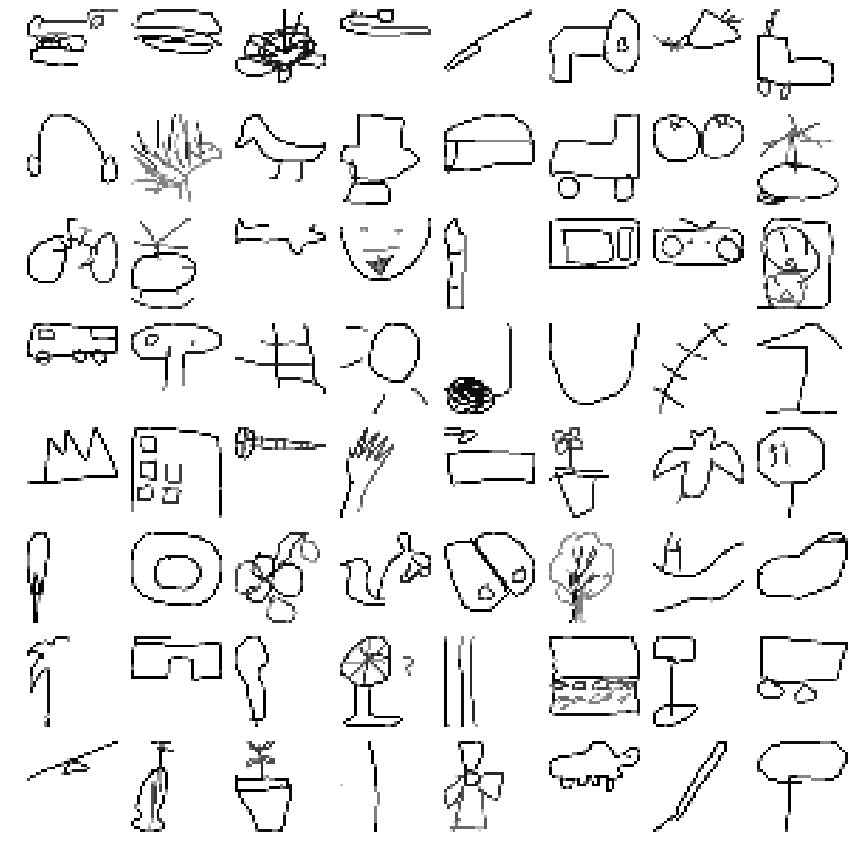

In [9]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gsdn.png', dpi=300)
plt.show();

In [10]:
x, y = next(train_datagen)

In [11]:


callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('DenseNet121,.h5', monitor='val_loss', verbose=0,save_best_only=False, save_weights_only=False, mode='auto', period=1),
]
hists=[]
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=70, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks=callbacks
)
hists.append(hist)


Epoch 1/70
1000/1000 [==============================] - 290s 290ms/step - loss: 3.1113 - categorical_crossentropy: 3.1113 - categorical_accuracy: 0.3445 - top_3_accuracy: 0.5157 - val_loss: 2.0471 - val_categorical_crossentropy: 2.0471 - val_categorical_accuracy: 0.5088 - val_top_3_accuracy: 0.7160
Epoch 2/70
1000/1000 [==============================] - 200s 200ms/step - loss: 1.8638 - categorical_crossentropy: 1.8638 - categorical_accuracy: 0.5467 - top_3_accuracy: 0.7485 - val_loss: 1.7100 - val_categorical_crossentropy: 1.7100 - val_categorical_accuracy: 0.5809 - val_top_3_accuracy: 0.7781
Epoch 3/70
1000/1000 [==============================] - 201s 201ms/step - loss: 1.6607 - categorical_crossentropy: 1.6607 - categorical_accuracy: 0.5920 - top_3_accuracy: 0.7851 - val_loss: 1.5752 - val_categorical_crossentropy: 1.5752 - val_categorical_accuracy: 0.6105 - val_top_3_accuracy: 0.8016
Epoch 4/70
1000/1000 [==============================] - 200s 200ms/step - loss: 1.5395 - categorical

1000/1000 [==============================] - 195s 195ms/step - loss: 1.1229 - categorical_crossentropy: 1.1229 - categorical_accuracy: 0.7126 - top_3_accuracy: 0.8742 - val_loss: 1.1166 - val_categorical_crossentropy: 1.1166 - val_categorical_accuracy: 0.7140 - val_top_3_accuracy: 0.8753
Epoch 28/70
1000/1000 [==============================] - 190s 190ms/step - loss: 1.1168 - categorical_crossentropy: 1.1168 - categorical_accuracy: 0.7138 - top_3_accuracy: 0.8752 - val_loss: 1.1069 - val_categorical_crossentropy: 1.1069 - val_categorical_accuracy: 0.7163 - val_top_3_accuracy: 0.8774orical_crossentropy: 1.1152 - categorical_accuracy: 0.7137 - top_3_accur - ETA: 52s - loss: 1.1153 - categorical_crossentropy: 1.1153 - categorical_accuracy: 0.713 - ETA: 48s - loss: 1.1151 - categorical_crossentropy: 1.1151 - categoric - ETA: 40s - loss: 1.1164 - categorical_crossentropy: 1.1164 - 
Epoch 29/70
1000/1000 [==============================] - 199s 199ms/step - loss: 1.1118 - categorical_crossent

1000/1000 [==============================] - 198s 198ms/step - loss: 0.9933 - categorical_crossentropy: 0.9933 - categorical_accuracy: 0.7443 - top_3_accuracy: 0.8918 - val_loss: 0.9837 - val_categorical_crossentropy: 0.9837 - val_categorical_accuracy: 0.7494 - val_top_3_accuracy: 0.8937
Epoch 50/70
1000/1000 [==============================] - 199s 199ms/step - loss: 0.9888 - categorical_crossentropy: 0.9888 - categorical_accuracy: 0.7448 - top_3_accuracy: 0.8926 - val_loss: 0.9835 - val_categorical_crossentropy: 0.9835 - val_categorical_accuracy: 0.7486 - val_top_3_accuracy: 0.8946
Epoch 51/70
1000/1000 [==============================] - 201s 201ms/step - loss: 0.9899 - categorical_crossentropy: 0.9899 - categorical_accuracy: 0.7461 - top_3_accuracy: 0.8930 - val_loss: 0.9817 - val_categorical_crossentropy: 0.9817 - val_categorical_accuracy: 0.7491 - val_top_3_accuracy: 0.8931
Epoch 52/70
1000/1000 [==============================] - 200s 200ms/step - loss: 0.9939 - categorical_crossen

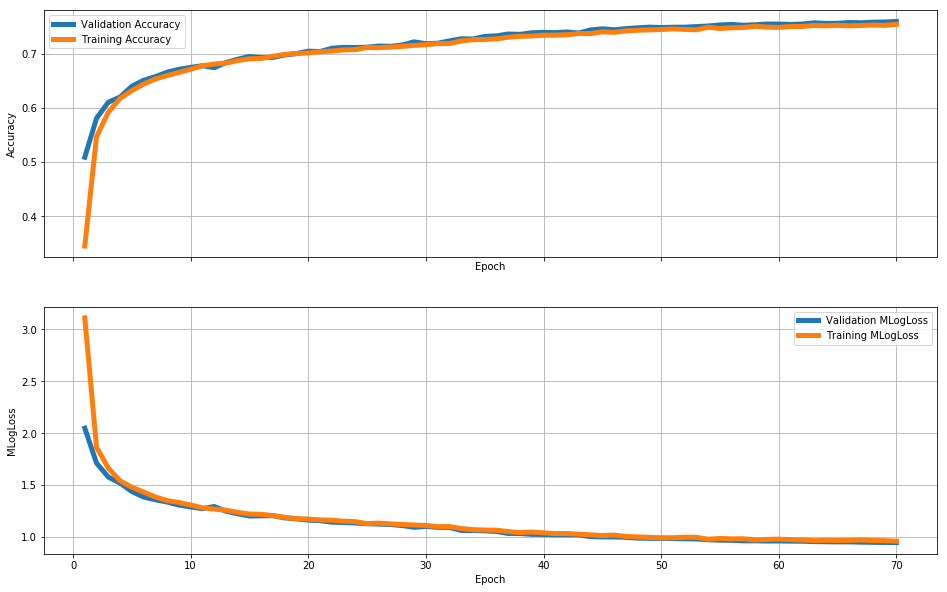

In [12]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist_densenet,.png', dpi=300)
plt.show();

In [13]:
hist_df.to_csv("history_of_Densenet,.csv")

In [14]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 14s 415us/step
Map3: 0.822


In [15]:
model.save_weights("Densenet,.h5")

In [20]:
model.load_weights("DenseNet121,.h5")

In [ ]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


In [17]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 41s 366us/step


,a,b,c
0,234,281,1
1,144,36,226
2,305,62,53
3,187,303,241
4,113,56,165


(112199, 3)

,a,b,c
0,radio,stereo,alarm_clock
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,camel
3,mountain,tent,roller_coaster
4,fireplace,campfire,leaf


(112199, 3)

In [18]:


test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_{}Densenet,.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape



,key_id,word
0,9000003627287624,radio stereo alarm_clock
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle camel
3,9000038588854897,mountain tent roller_coaster
4,9000052667981386,fireplace campfire leaf


(112199, 2)

In [19]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2019-01-11 05:01:54.186208.
Total time 14096s
